In [211]:
from os import environ
from sqlalchemy import create_engine
import pandas as pd

In [335]:
user_df = pd.read_sql_table(
    "user",
    con=engine,
    schema='public',
    coerce_float=True,
    parse_dates=['created_at'],
)

chat_df = pd.read_sql_table(
    "chat_message",
    con=engine,
    schema='public',
    index_col = 'id',
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)
group_df = pd.read_sql_table(
    "group",
    con=engine,
    schema='public',
    index_col = 'name',
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)

workout_df = pd.read_sql_table(
    "workout",
    con=engine,
    schema='public',
    index_col = 'id',
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)


user_exercise_df = pd.read_sql_table(
    "user_exercise",
    con=engine,
    schema='public',
    index_col = ['slug_name', 'username'],
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)

battle_df = pd.read_sql_table(
    "battle",
    con=engine,
    schema='public',
    coerce_float=True,
    parse_dates=[
        'created_at',
        'updated_at'
    ],
)


session_analytics_df = pd.read_sql('select id, username, created_at, array_to_json(analytics) as path from "session_analytics"', con = engine)






In [213]:
from datetime import datetime, timedelta
created_at = session_analytics_df.iloc[0]['created_at']
sections = []

for row in session_analytics_df.iterrows():
    for section in row[1]['path']:
        sections.append([row[1]['id'], section['section'], created_at])
        created_at += timedelta(seconds=section['time_spent'])

In [214]:
section_to_ID = {"strengthModalVisible": 0,
                 "workoutModalVisible": 1,
                 "chatModalVisible": 2,
                 "UserTab": 3,
                 "MembersTab": 4, 
                 "EnemyTab": 5}
#[i][j] should denote the number of times i lead to j
section_before_after = [[0 for i in range(7)] for i in range(7)]

In [215]:
for row in session_analytics_df.iterrows():
    previous_section_id = None
    for section in row[1]['path']:
        try:
            current_id = section_to_ID[section['section']]
        except:
            continue
        if previous_section_id != None: 
            section_before_after[previous_section_id][current_id] += 1
        previous_section_id = current_id

for i in range(7):
    section_before_after[i][i] = 0

In [216]:
source = []
target = []
value = []
for r in range(7):
    for c in range(7):
        count = section_before_after[r][c]
        if count:
            source.append(r)
            target.append(c)
            value.append(count)
            
source_colors = ["orange", "green", "red", "purple", "brown", "gray"]
color = [source_colors[val] for val in source]

In [218]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "blue", width = 0.5),
      label = ["Track Personal Best", "Track Workout", "Open Chat", "View Your Character", "View Team's Members", "View Team's Monster"],
      color = "blue",
      x = [0, 1],
      y = [0, 1]
    ),
    link = dict(
      source = source,
      target = target,
      value = value,
      color = color
  ))])

fig.update_layout(title_text="", font_size=12)
fig.show()

In [309]:
import math
user_with_counts = user_df
counts = user_with_counts.groupby('groupname').count().reset_index().rename(columns = {"created_at": "Number of members"})[['groupname', 'Number of members']]
user_with_counts = user_with_counts.merge(counts, on = "groupname", how = "left")
user_with_counts['Number of members'] = user_with_counts['Number of members'].apply(lambda x:  0 if math.isnan(x) else x)

counts = workout_df.groupby('username').count().reset_index().rename(columns = {"created_at": "Tracked workouts"})[['username', 'Tracked workouts']]
user_with_counts = user_with_counts.merge(counts, on = "username", how = "left")
user_with_counts['Tracked workouts'] = user_with_counts['Tracked workouts'].apply(lambda x:  0 if math.isnan(x) else x)

counts = user_exercise_df.groupby('username').count().reset_index().rename(columns = {"created_at": "Tracked personal bests"})[['username', 'Tracked personal bests']]
user_with_counts = user_with_counts.merge(counts, on = "username", how = "left")
user_with_counts['Tracked personal bests'] = user_with_counts['Tracked personal bests'].apply(lambda x:  0 if math.isnan(x) else x)

counts = chat_df.groupby('username').count().reset_index().rename(columns = {"created_at": "Chat messages"})[['username', 'Chat messages']]
user_with_counts = user_with_counts.merge(counts, on = "username", how = "left")
user_with_counts['Chat messages'] = user_with_counts['Chat messages'].apply(lambda x:  0 if math.isnan(x) else x)

counts = session_analytics_df.groupby('username').count().reset_index().rename(columns = {"created_at": "Number of app opens"})[['username', 'Number of app opens']]
user_with_counts = user_with_counts.merge(counts, on = "username", how = "left")
user_with_counts['Number of app opens'] = user_with_counts['Number of app opens'].apply(lambda x:  0 if math.isnan(x) else x)






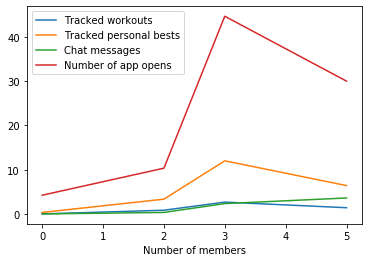

In [316]:
import matplotlib as plt
to_plot = user_with_counts.groupby('Number of members').mean()
#to_plot.drop(columns = ['Number of app opens']).plot()
to_plot.plot()

In [346]:

#battle_workout_merge = workout_df.rename(columns = {"created_at": "workout_created_at"}).merge(battle_df, on = ["groupname", 'battle_number'])
#battle_workout_merge.rename(columns = {"created_at": "battle_created_at"})






NameError: name 'clear' is not defined

In [370]:
def get_end_date(row):
    next_battle = battle_df[battle_df['groupname'] == row['groupname']]
    next_battle = next_battle[battle_df['battle_number'] == row['battle_number'] + 1]
    if len(next_battle):
        row['ended_at'] = next_battle.iloc[0]['created_at']
    return row
battle_df.apply(get_end_date, axis = 1)

<ipython-input-370-9867e462a96c>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-370-9867e462a96c>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-370-9867e462a96c>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-370-9867e462a96c>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-370-9867e462a96c>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-370-9867e462a96c>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-370-9867e462a96c>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-370-9867e462a96c>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.

<ipython-input-370-9867e462a96c>:3: UserWarning:

Boolean Series key will be reindexed t

,battle_number,created_at,current_health,ended_at,enemy_level,groupname,max_health,updated_at
0,1,2021-02-21 11:43:48.864087+00:00,-2.193333,2021-02-24 19:30:18.162930+00:00,1,Team Jokr,20.0,2021-02-24 19:30:18.162930+00:00
1,5,2021-02-24 01:11:05.233365+00:00,14.470000,NaT,5,Soy,48.0,2021-02-25 16:02:09.852473+00:00
2,3,2021-02-21 17:50:26.969291+00:00,-7.060000,2021-02-26 13:09:56.200762+00:00,3,Punet,60.0,2021-02-26 13:09:56.200762+00:00
3,4,2021-02-26 13:09:56.200762+00:00,51.150000,NaT,4,Punet,70.0,2021-02-26 18:33:08.689523+00:00
4,2,2021-02-24 19:30:18.162930+00:00,0.400000,2021-02-26 21:14:52.155480+00:00,2,Team Jokr,20.0,2021-02-26 21:14:52.155480+00:00
5,3,2021-02-26 21:14:52.155480+00:00,24.000000,NaT,3,Team Jokr,24.0,2021-02-26 21:14:52.155480+00:00
6,1,2021-02-21 16:08:07.316906+00:00,20.000000,NaT,1,Roistot,20.0,2021-02-21 16:08:07.316906+00:00
7,1,2021-02-21 17:39:49.822013+00:00,-0.650000,2021-02-21 17:42:17.982947+00:00,1,Punet,20.0,2021-02-21 17:42:17.982947+00:00
8,2,2021-02-21 17:42:17.982947+00:00,-8.560000,2021-02-21 17:50:26.969291+00:00,2,Punet,20.0,2021-02-21 17:50:26.969291+00:00
9,1,2021-02-22 11:09:29.318665+00:00,12.150000,NaT,1,Calisthenics,20.0,2021-02-22 18:37:17.045033+00:00
